<a href="https://colab.research.google.com/github/prithvikavoori/DogBreedClassificationModel/blob/main/dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## end to end multi class dog breed classification

this notebook builds an end to end multi class image classifier using TensorFlow 2.0 and TensorFlow Hub

### Problem
identifying the breed of dog given the image of a dog
### Data

the data we are using is from kaggle
[link text](https://www.kaggle.com/c/dog-breed-identification/d)

### Evaluation
the evaluation is afile with prediction probabilities of each dog breed of each test image 

### Features
Some information about the data.
* we are dealing with images (unstructured data) so its better to use deep learning and transfer learning.

* there are 120 diffrent breeds of dogs( that is 120 diffrent classes)

* There are around 10000 + images in the training set (images with labels)and test set these images(these images have no labels)


In [46]:
#unzip the uploaded data in to google drive
#!unzip "drive/MyDrive/Dog_vision/dog-breed-identification (1).zip" -d "drive/MyDrive/Dog_vision"

### get our workspace ready
* Import tensorflow
* Import TensorFlowHub
* Make sure we are using a GPU

In [47]:
# Import TensorFlow and Tensorflowhub into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF Version", tf.__version__)
print("TF_hub version", hub.__version__)

# check for GPU availability 
print("GPU", "available (Yesss!!!)" if tf.config.list_physical_devices("GPU")else "not available" )

TF Version 2.5.0
TF_hub version 0.12.0
GPU available (Yesss!!!)


### getting our data ready  
* in machine learning all data must be in numerical format. so that is what we will be doing first. turning our images in to tensors (numerical representation)
* lets start by accessing our data and checking out the labels 

In [48]:
# checkout the labels of our data 
import pandas as pd
labels_csv=pd.read_csv("drive/MyDrive/Dog_vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     151474b992b295f69547839e31271dd0  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [49]:
# how many images are there for each breed 
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

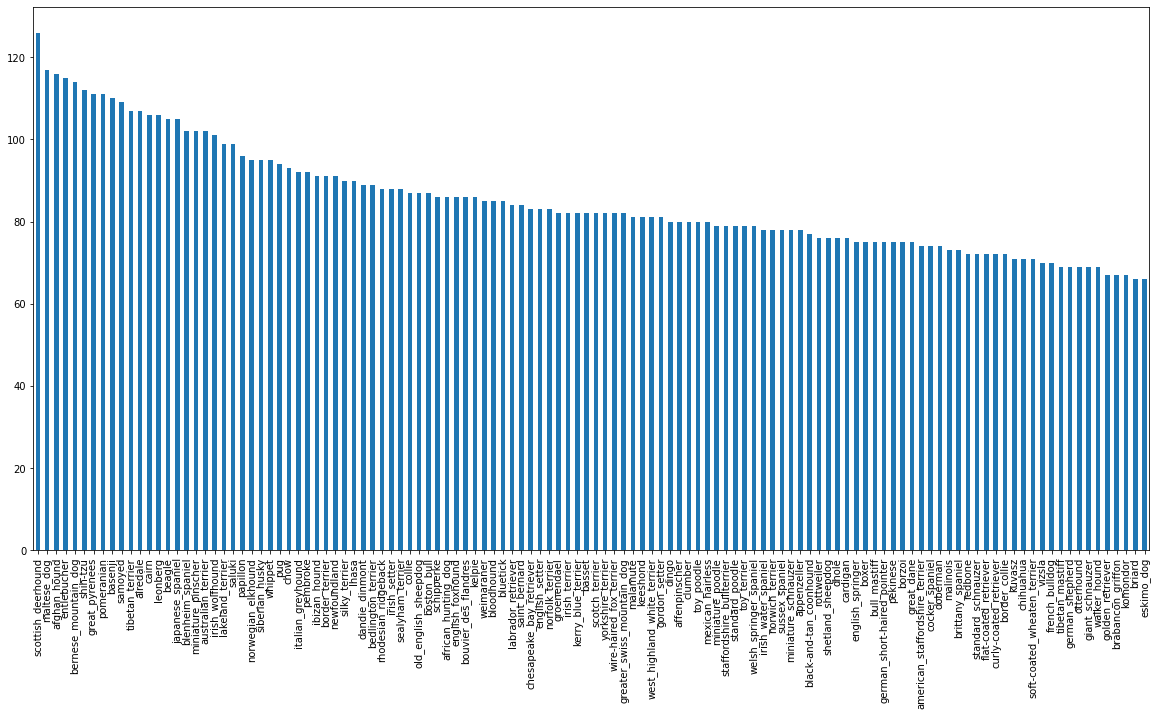

In [50]:
#visualizing the above cell information

labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [51]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

In [52]:
labels_csv["breed"].value_counts().median()

82.0

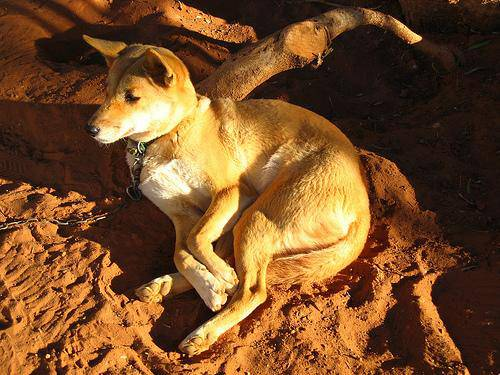

In [53]:
#lets view an image
from IPython.display import Image
Image("drive/MyDrive/Dog_vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels 

lets get a list of all our image file path names 

In [54]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [55]:
# create pathnames from Image ids
filenames=["drive/MyDrive/Dog_vision/train/"+fname+".jpg" for fname in labels_csv["id"]]

#check first 10
filenames[:10]

['drive/MyDrive/Dog_vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog_vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog_vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog_vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog_vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog_vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog_vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog_vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog_vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog_vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [56]:
#check whether number of file name matches the number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog_vision/train/"))==len(filenames):
  print("filenames match actual amount of files!!!!!")
else:
  print("filenames donot match actual amount of files, check the target directory")

filenames match actual amount of files!!!!!


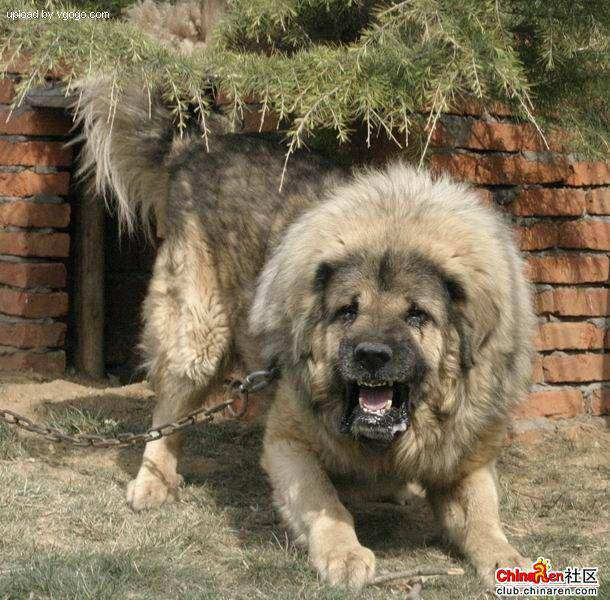

In [57]:
Image(filenames[9000])

In [58]:
labels_csv["breed"][9000]

'tibetan_mastiff'

since we have now got our training image filepaths in a list, lets prepare our labels 

In [59]:
import numpy as np
labels =labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [60]:
len(labels)

10222

In [61]:
# see if number of labels matches the number of filenames 
if len(labels)== len(filenames):
  print("number of labels matches number of filenames")
else:
  print("they donot match")

number of labels matches number of filenames


In [62]:
#find the unique label values
unique_breeds=np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [63]:
unique_breeds=np.unique(labels)
len(unique_breeds)

120

In [64]:
# turn a label in to an array of booleans 
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [65]:
# turn every label into a boolean array 
boolean_labels= [labels==unique_breeds for labels in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [66]:
len(boolean_labels)

10222

In [67]:
#Example turning a boolean array in to integer 
print(labels[0]) #original label
print(np.where(unique_breeds==labels[0]))#index where label occurs
print(boolean_labels[0].argmax())# index where label occurs in boolean array
print(boolean_labels[0].astype(int))# there will be 1 where the sample label occurs  

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [68]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own bvalidation set .

since the data set from kaggle doesnot provide any validation set. we are going to create our own 

In [69]:
# set up X and y variables
X= filenames
y=boolean_labels

we are going to start off experimenting with 10000 images and increase as needed

In [70]:
#set the number of images to use for experimenting
NUM_IMAGES=1000 #@param {type:"slider",min:1000, max:10000,step:1000}

In [71]:
#lets split our data in to train set and validation set
from sklearn.model_selection import train_test_split

#Split them in to training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val= train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],
                                                 test_size=0.2, random_state=42)
len(X_train), len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

In [72]:
#lets look at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog_vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog_vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog_vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog_vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog_vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

### Preprocessing images (turning images in to tensors)

To preprocess our images in to tensors we are going to write a function which does a few things:
* Take an image filepath as input 
* Use tensorflow to read the files and save it into variables image 
* turn our image (a.jpg) in to tensors
* Normalize our images (convert our images color channel from 0-255 to 0-1)
* Resize the image to be a shape of (224,224)
* Return the modified image 

In [73]:
#before we create a function lets look at what importing an image looks like
from matplotlib.pyplot import imread
image=imread(filenames[42])
image.shape

(257, 350, 3)

In [74]:
image.max(),image.min()

(255, 0)

In [75]:
#This is how the image looks after converting it in to numpy array
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [76]:
#convert numpy array image in numpy array to tensor 

tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [77]:
# Define image size 
IMG_SIZE= 224

#create a function for preprocessing images 
def process_image(image_path, img_size=IMG_SIZE):
  """
  take the image file path and turns the image in to tensor 
  """
  # Read in image file 
  image = tf.io.read_file(image_path)
  
  # turn the .jpg image in to  numerical  Tensors with 3 color channels (RGB)
  image=tf.image.decode_jpeg(image,channels=3)
  
  #  convert the colour channel values from 0-255 to 0-1 values
  image=tf.image.convert_image_dtype(image,tf.float32)

  # resize the image to our desired value (224,224)
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image



## Turning our data in to batches 
* lets say you are trying to fit all the 10000 + photos in one go the GPU wikk not be able to handle such large data so we divide them in to batches which is max size is 32 photos

* In order to use TensorFlow effectively, we need our data in form of Tensor tuple which looks like this (image, label)



In [78]:
# creating a function which returns a tensor tuple 

def get_img_label(image_path, label):
  """
  Takes an image file path and the associated label,
  process the images and returns a type of (image,label).
  """
  image=process_image(image_path)
  return image,label



In [79]:
# demo of the above 

(process_image(X[42]),tf.constant(y[42]))


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

A way to turn our data in to tupples and tensors. lets make a function that turns all our data in to batches 

In [80]:
# creating afunction to turn all our data in to data baches of size 32

#defining a batch size
BATCH_SIZE= 32

#creating a function

def create_data_batches(X,y=None,batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  creates batches of data out of image (X) and label (y) pairs.
  shuffle the data if it is a training data but doesnt shuffle validation data.
  Also accepts test data as input (no labels).
  """
  # if data is the test dataset , we probably dont have labels
  if test_data:
    print("Creating test data batches")
    data =tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch=data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  #if data is valid dataset we dont have to shuffle the data set 
  elif valid_data:
    print("Creating validation data batches...")
    data =tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch=data.map(get_img_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("creating training data batches..")
    # Turn file paths and labels in to tensors 
    data =tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))

    #shuffling pathnames and label before mapping image processor function is faster than shuffling images
    data=data.shuffle(buffer_size=len(X))

    #create (imge,label) tupples (this also turns the image path into processed image)

    data= data.map(get_img_label)

    # Turn the training data in to batches 
    data_batch=data.batch(BATCH_SIZE)
  return data_batch

In [81]:
# create  training and validation data 

train_data= create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val, valid_data=True)

creating training data batches..
Creating validation data batches...


In [82]:
#checkout the diffrent attributes of our data batches 
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches 
our data 

In [83]:
import matplotlib.pyplot as plt

#create a function for viewing images in a data batch
def show_25_image(images, labels):
  """
  displays a plot of 25 images and their labels from a batch 
  """
  #setup the fig 
  plt.figure(figsize=(10,10))
  for i in range(25):
    #create subplots (5 rows, 5 columns)
    ax=plt.subplot(5,5,i+1) 
    # Display an image
    plt.imshow(images[i])
    #add the image label as title 
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [84]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [85]:
train_images, train_labels = next(train_data.as_numpy_iterator())

len(train_images), len(train_labels)

(32, 32)

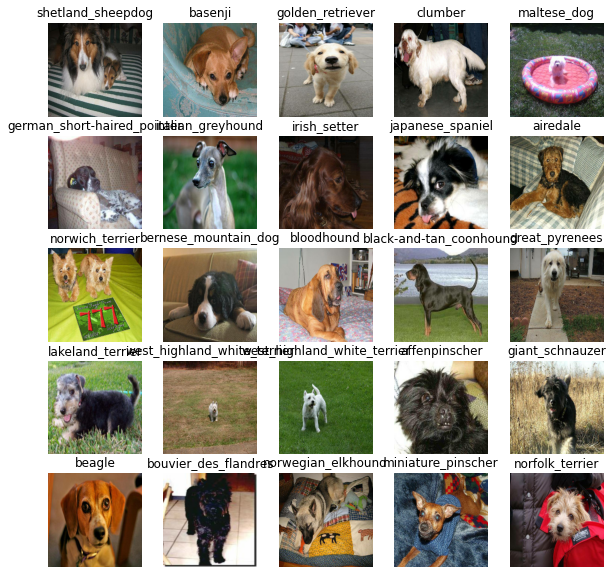

In [86]:
# now lets visualize the data in a training batch 
show_25_image(train_images, train_labels)

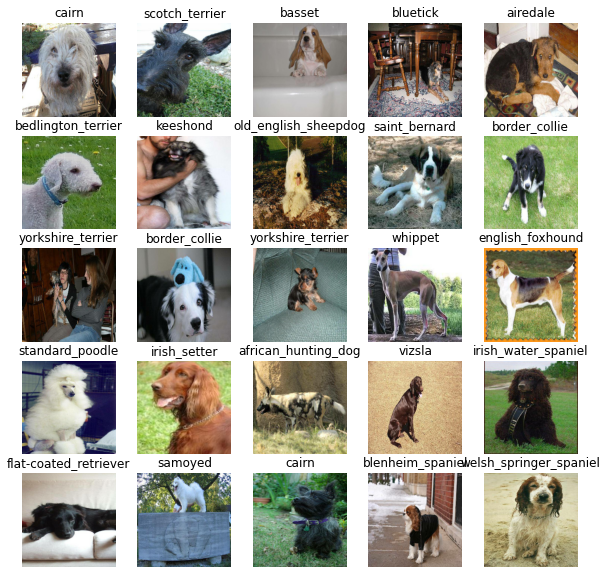

In [87]:
#Now let us visualize our validation set 
val_images, val_labels=next(val_data.as_numpy_iterator())
show_25_image(val_images, val_labels)

### Building a model
before we build a model, there are a few things we need to define

* the input shape (our image shape, in the form of Tensors) to our model.
* the output shape (image labels, in the form of Tensors) of our model.
* the URL of the model we want to use from TensorFlow Hub.
https://tfhub.dev/s?module-type=image-classification


In [88]:
# setup input shape to the model 
INPUT_SHAPE=[None, IMG_SIZE, IMG_SIZE, 3]
# setup output shape of our model 
OUTPUT_SHAPE=len(unique_breeds)
# setup model URL from TensorFLow Hub 
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we have input output and our model ready .lets put them together in to a keras deep learning model

Lets create a function
* takes the input shape output shape and the model we have chosen as input 
* defines the layers in karas model in sequential fashion 
* Compiles the model (says it should be evaluated and improved)
* builds the model  (tells the model the input shape it will be getting)
* Returns the model 



In [89]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [90]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

###TensorBoard Callback
To setup a TensorBoard callback, we need to do 3 things:

Load the TensorBoard notebook extension ✅
Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function. ✅
Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [91]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [93]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Dog_vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [94]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

### Training a model (on subset of data)¶
Our first model is only going to train on 1000 images, to make sure everything is working.


In [95]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}


Let's create a function which trains a model.

* Create a model using create_model()
* Setup a TensorBoard callback using create_tensorboard_callback()
* Call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

In [96]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [98]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 146s 5s/step - loss: 4.4671 - accuracy: 0.1187 - val_loss: 3.4496 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 3s 115ms/step - loss: 1.5828 - accuracy: 0.7038 - val_loss: 2.2553 - val_accuracy: 0.4600
Epoch 3/100
25/25 [==============================] - 3s 117ms/step - loss: 0.5607 - accuracy: 0.9413 - val_loss: 1.7793 - val_accuracy: 0.5500
Epoch 4/100
25/25 [==============================] - 3s 117ms/step - loss: 0.2531 - accuracy: 0.9837 - val_loss: 1.5683 - val_accuracy: 0.5800
Epoch 5/100
25/25 [==============================] - 3s 117ms/step - loss: 0.1461 - accuracy: 0.9950 - val_loss: 1.4812 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 3s 116ms/step - loss: 0.0988 - accuracy: 1.0000 - val_loss: 1.4240 - val_accuracy: 0.6350
Epoch 7/100
25/25 [==============================]

## Checking the TensorBoard logs
The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and visualize its contents.

In [106]:

%tensorboard --logdir drive/MyDrive/Dog_vision/logs

Reusing TensorBoard on port 6007 (pid 701), started 0:01:36 ago. (Use '!kill 701' to kill it.)

<IPython.core.display.Javascript object>

In [107]:
!kill 701


### Making and evaluating predictions using a trained model

In [108]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 80ms/step


array([[4.9710466e-04, 3.5803670e-05, 9.0611458e-04, ..., 9.9559024e-05,
        3.8957995e-05, 1.4028504e-03],
       [2.8098500e-03, 1.2163825e-03, 1.3601872e-02, ..., 1.6482425e-04,
        2.2222453e-03, 4.0146941e-04],
       [3.2020596e-06, 2.9004346e-05, 3.5666510e-06, ..., 1.5955244e-05,
        6.7683854e-06, 1.2380682e-04],
       ...,
       [2.8877335e-07, 8.0572827e-06, 1.1366865e-06, ..., 3.6651770e-06,
        3.6129127e-06, 6.4998640e-06],
       [4.3455069e-03, 1.3612703e-04, 4.2005177e-05, ..., 3.6053356e-05,
        1.7633567e-05, 2.2847524e-03],
       [5.0726645e-05, 5.7855450e-05, 5.2638695e-04, ..., 2.6172108e-03,
        2.2084024e-03, 3.1485262e-05]], dtype=float32)

In [109]:
predictions[0]

array([4.97104658e-04, 3.58036705e-05, 9.06114583e-04, 1.86958772e-04,
       7.38087518e-04, 4.86222461e-06, 1.07916137e-02, 3.39146616e-04,
       3.84680752e-05, 1.25625858e-03, 4.39947122e-04, 1.31316832e-04,
       4.86579200e-04, 2.90273983e-05, 3.23562592e-04, 9.48208210e-04,
       2.18765781e-05, 8.99806917e-02, 5.65745613e-05, 1.60467054e-04,
       3.98989767e-04, 5.51303601e-05, 1.64119174e-05, 3.60410847e-03,
       6.65444459e-05, 1.07236148e-04, 2.78391868e-01, 2.68994685e-04,
       8.07086413e-04, 8.86095295e-05, 2.03709606e-05, 3.19372542e-04,
       4.41087934e-04, 2.90245462e-05, 5.05142438e-04, 1.76834445e-02,
       3.39910766e-05, 1.81632116e-04, 8.14174346e-05, 2.11773484e-04,
       5.05532080e-04, 7.75261924e-06, 1.14335373e-04, 4.44792495e-05,
       1.21586054e-05, 9.89451073e-05, 1.02544009e-05, 8.04688025e-05,
       1.70773448e-04, 3.13098062e-05, 5.30444486e-05, 9.36151773e-05,
       1.64314246e-04, 5.73060643e-05, 1.81576252e-04, 1.54123889e-04,
      

In [110]:
np.sum(predictions[0])

0.9999999

In [111]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[4.28335188e-05 6.79972482e-06 1.03562261e-05 8.36708296e-06
 8.42995767e-04 1.66719856e-05 8.94277582e-06 5.07037388e-04
 3.84695735e-03 2.39606462e-02 1.33129352e-05 2.16137369e-06
 2.29207159e-04 1.22106262e-03 4.44011966e-04 1.18516781e-03
 4.62839398e-06 1.17351250e-04 3.27632661e-05 1.42712772e-04
 7.02306761e-06 2.13927342e-04 1.13839114e-05 5.26409030e-06
 6.51204493e-03 1.07063541e-04 1.66933205e-05 5.91596618e-05
 1.24350292e-04 7.94776279e-05 6.65968109e-05 5.52210186e-05
 2.01196744e-05 2.04612388e-05 1.66442333e-05 1.58437178e-05
 9.30400565e-05 1.23196703e-04 3.26771114e-05 1.11781307e-01
 2.97754432e-05 8.68340521e-06 1.29530393e-03 2.36013193e-06
 1.21896890e-04 2.62020676e-05 3.06783419e-04 1.68549625e-04
 4.22764560e-06 1.07354310e-04 3.39497965e-05 5.69249823e-05
 1.05307816e-04 1.21252891e-03 1.93136166e-05 1.41203971e-04
 6.05006462e-05 2.90657008e-05 8.71518423e-05 3.81931059e-05
 5.97839353e-05 1.60538635e-04 1.20183768e-06 7.34808127e-05
 1.76881076e-04 3.042941

In [112]:
unique_breeds[113]

'walker_hound'

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

Note: Prediction probabilities are also known as confidence levels.

In [114]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[113])
pred_label

'toy_poodle'


Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [116]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:

* Prediction labels
* Validation labels (truth labels)
* Validation images
Let's make some function to make these all a bit more visaulize.

We'll create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [117]:
# creating above mentioned function 

def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

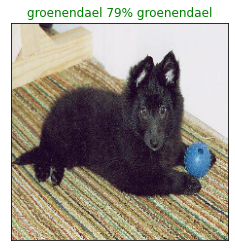

In [120]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using get_pred_label() ✅
* Find the top 10:
 * Prediction probabilities indexes ✅
 * Prediction probabilities values ✅
 * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [121]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

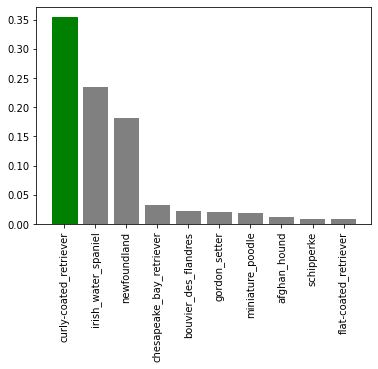

In [123]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=84)

### Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

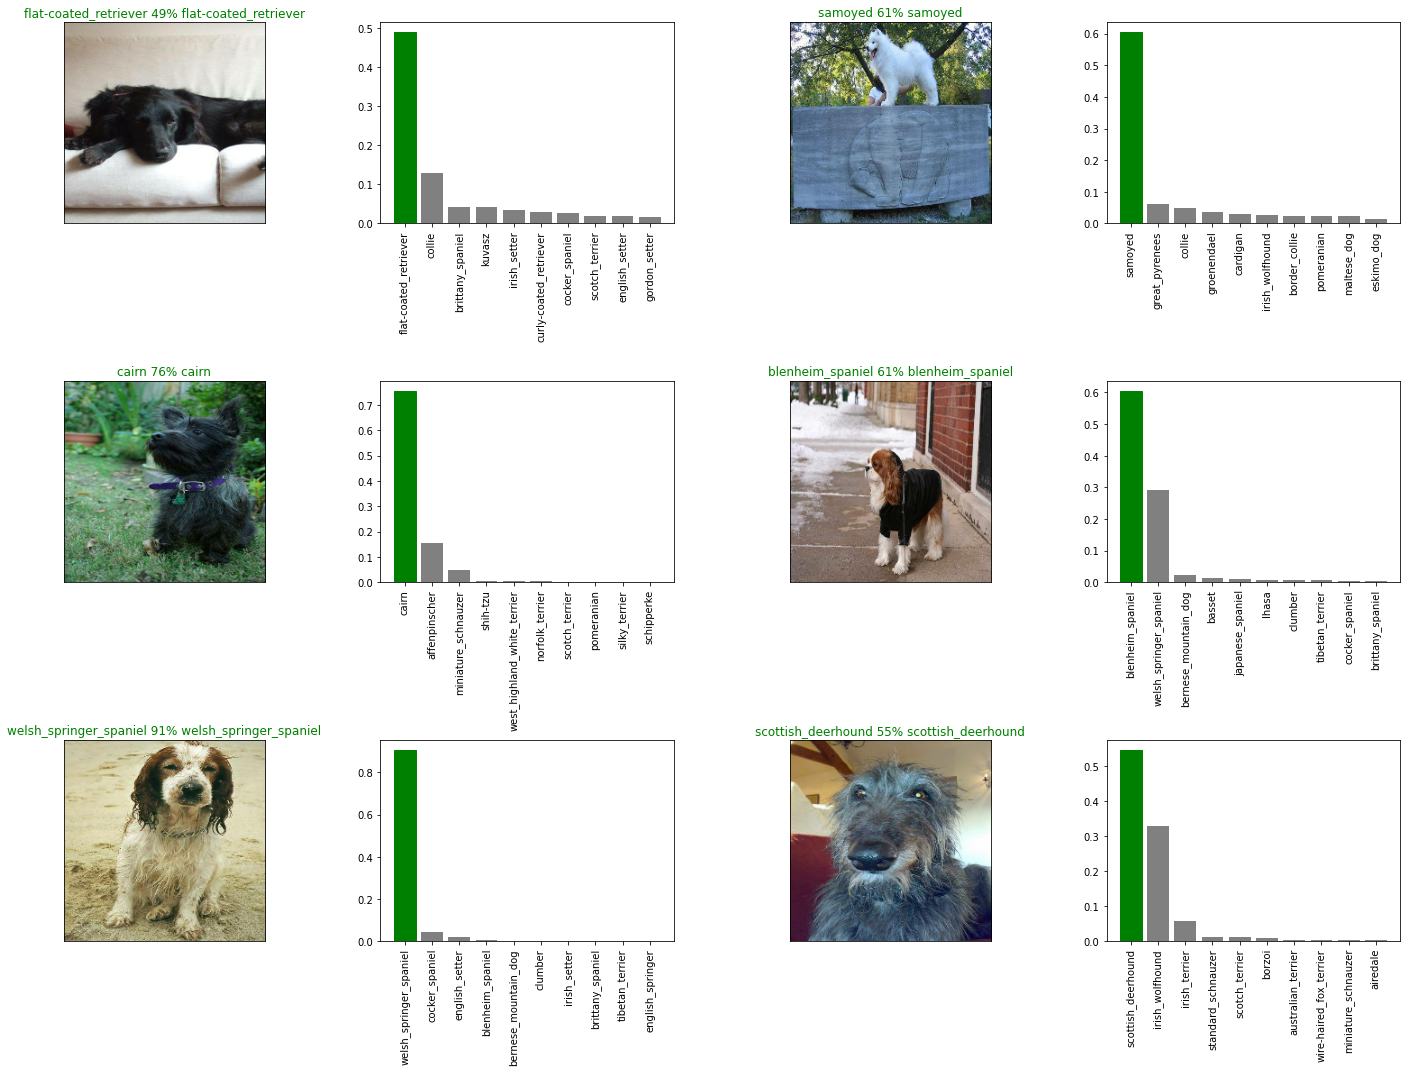

In [125]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and training a model 

In [129]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dog_vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [130]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model


Now we've got functions to save and load a trained model, let's make sure they work!

In [131]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog_vision/models/20210808-01181628385524-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog_vision/models/20210808-01181628385524-1000-images-mobilenetv2-Adam.h5'

In [133]:
# Load a trained model
loaded_1000_image_model = load_model('drive/MyDrive/Dog_vision/models/20210808-01181628385524-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog_vision/models/20210808-01181628385524-1000-images-mobilenetv2-Adam.h5


In [134]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 76ms/step - loss: 1.2754 - accuracy: 0.6850


[1.275420904159546, 0.6850000023841858]

In [135]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 74ms/step - loss: 1.2754 - accuracy: 0.6850


[1.275420904159546, 0.6850000023841858]

### Training dog model on full data 


In [136]:
len(X), len(y)

(10222, 10222)

In [137]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

creating training data batches..


In [138]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [139]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [140]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

Note runing the below cell will take a quite long time as we are training the model on full data 

In [141]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1229s 4s/step - loss: 1.3415 - accuracy: 0.6657
Epoch 2/100
320/320 [==============================] - 31s 97ms/step - loss: 0.3997 - accuracy: 0.8844
Epoch 3/100
320/320 [==============================] - 32s 99ms/step - loss: 0.2359 - accuracy: 0.9339
Epoch 4/100
320/320 [==============================] - 30s 93ms/step - loss: 0.1558 - accuracy: 0.9622
Epoch 5/100
320/320 [==============================] - 31s 95ms/step - loss: 0.1070 - accuracy: 0.9778
Epoch 6/100
320/320 [==============================] - 31s 97ms/step - loss: 0.0774 - accuracy: 0.9857
Epoch 7/100
320/320 [==============================] - 30s 94ms/step - loss: 0.0576 - accuracy: 0.9919
Epoch 8/100
320/320 [==============================] - 31s 98ms/step - loss: 0.0449 - accuracy: 0.9956
Epoch 9/100
320/320 [==============================] - 30s 92ms/step - loss: 0.0372 - accuracy: 0.9959
Epoch 10/100
320/320 [==============================] - 31s 95ms/step - l

In [142]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog_vision/models/20210808-01591628387962-full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog_vision/models/20210808-01591628387962-full-image-set-mobilenetv2-Adam.h5'

In [143]:

# Load in the full model
loaded_full_model = load_model('drive/MyDrive/Dog_vision/models/20210808-01591628387962-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog_vision/models/20210808-01591628387962-full-image-set-mobilenetv2-Adam.h5



## Making predictions on the test dataset
Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created create_data_batches() earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames. ✅
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the predict() method called on our model.

In [144]:
# Load test image filenames
test_path = "drive/MyDrive/Dog_vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Dog_vision/test/e49bfa1dc9bc6fa7464b29507725b3af.jpg',
 'drive/MyDrive/Dog_vision/test/e4d878f113883a3caab47d3126d2c2a4.jpg',
 'drive/MyDrive/Dog_vision/test/deac194013c246095f0e88cd8b6b90d2.jpg',
 'drive/MyDrive/Dog_vision/test/dd026c42cfd91ea64b1fe5db04a18863.jpg',
 'drive/MyDrive/Dog_vision/test/e4c37f2fbeabc98e168ebf4abce59370.jpg',
 'drive/MyDrive/Dog_vision/test/e079440ee0061b92ec22faf17be13908.jpg',
 'drive/MyDrive/Dog_vision/test/e1c6c50bbaee219e7faf29e9c1c343ca.jpg',
 'drive/MyDrive/Dog_vision/test/e7e9dd51302fe08c1c89a550e183cf07.jpg',
 'drive/MyDrive/Dog_vision/test/e06ce40d62d3d198f2df70349104a002.jpg',
 'drive/MyDrive/Dog_vision/test/df4a5ab3464b937e11467c395ed190b9.jpg']

In [145]:
len(test_filenames)

10357

In [146]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches


In [147]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>


Note: Calling predict() on our full model and passing it the test data batch will take a long time to run (about a ~1hr). This is because we have to process ~10,000+ images and get our model to find patterns in those images and generate predictions based on what its learned in the training dataset.

In [148]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 1508s 5s/step


In [151]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/MyDrive/Dog_vision/preds_array.csv", test_predictions, delimiter=",")

In [154]:
#Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/MyDrive/Dog_vision/preds_array.csv", test_predictions, delimiter=",")

TypeError: ignored

In [155]:

test_predictions[:10]

array([[5.5355951e-08, 5.2909526e-09, 4.1119752e-10, ..., 8.7752292e-11,
        7.0938194e-10, 2.0088771e-06],
       [4.1090395e-10, 3.2236352e-10, 9.8778896e-10, ..., 3.6725251e-07,
        4.1708983e-10, 3.4321477e-08],
       [5.8416497e-08, 1.9594286e-06, 3.2594333e-08, ..., 4.0644289e-07,
        3.3877481e-04, 1.3023865e-05],
       ...,
       [1.4633927e-04, 1.2310825e-07, 8.3392875e-09, ..., 1.5969832e-07,
        3.8336184e-06, 9.7948921e-01],
       [4.4663150e-07, 7.2920157e-05, 1.8518453e-08, ..., 3.9638157e-06,
        2.8201989e-06, 2.6656810e-08],
       [3.7343826e-09, 1.5770248e-11, 2.9729355e-12, ..., 5.5479146e-09,
        2.2495840e-06, 2.0447892e-10]], dtype=float32)

In [156]:
test_predictions.shape

(10357, 120)

##Preparing test dataset predictions for Kaggle
Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [157]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [158]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [159]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e49bfa1dc9bc6fa7464b29507725b3af,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e4d878f113883a3caab47d3126d2c2a4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,deac194013c246095f0e88cd8b6b90d2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dd026c42cfd91ea64b1fe5db04a18863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e4c37f2fbeabc98e168ebf4abce59370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e49bfa1dc9bc6fa7464b29507725b3af,5.5356e-08,5.29095e-09,4.11198e-10,7.28442e-10,8.21671e-09,2.54742e-08,3.45508e-08,1.23941e-09,5.06101e-08,3.41921e-07,5.47864e-10,5.13575e-06,1.4163e-09,0.999232,5.65828e-09,4.09523e-08,9.8272e-10,2.70276e-08,3.32569e-10,1.19033e-07,1.14961e-09,6.07007e-08,1.24634e-07,8.93049e-10,0.000153664,6.22919e-09,1.13479e-07,1.24617e-10,2.08371e-09,2.64273e-07,4.70212e-09,1.45088e-05,9.59318e-05,4.63284e-09,4.45347e-11,6.6354e-09,5.68862e-09,5.66606e-11,1.48477e-10,...,4.93398e-10,2.21547e-09,1.06089e-10,1.20719e-09,6.19973e-05,1.5482e-06,4.9754e-07,4.01902e-08,1.42277e-10,2.38475e-09,3.95464e-10,7.82183e-10,9.10498e-07,2.77448e-09,2.03733e-09,1.50561e-09,1.65277e-09,5.03836e-11,5.24323e-08,1.6794e-07,2.38973e-06,2.81387e-08,1.54825e-07,2.1652e-08,3.92249e-09,5.24024e-09,2.00121e-09,5.68142e-06,1.72251e-10,6.69379e-09,8.17902e-08,2.51541e-09,1.09799e-07,1.45618e-10,6.90428e-10,9.06652e-07,1.3331e-09,8.77523e-11,7.09382e-10,2.00888e-06
1,e4d878f113883a3caab47d3126d2c2a4,4.10904e-10,3.22364e-10,9.87789e-10,2.44092e-11,3.09872e-10,2.4818e-12,2.44159e-11,1.56195e-11,1.10145e-08,6.0578e-10,9.04139e-07,4.27429e-12,2.71138e-09,2.78646e-11,6.18934e-10,0.0250306,5.11959e-10,1.64995e-07,4.47647e-13,2.23699e-07,1.16205e-09,7.79264e-09,8.50155e-12,4.84891e-12,1.91578e-08,1.3915e-10,2.87811e-10,4.74117e-12,6.93786e-08,2.33222e-09,3.04158e-13,2.50313e-10,2.57707e-11,9.07067e-09,1.08104e-07,5.573e-11,2.15469e-11,1.01855e-11,6.99371e-08,...,2.75583e-09,1.91268e-12,1.72532e-09,9.18321e-10,2.97983e-10,4.07465e-13,2.47981e-13,9.62895e-12,1.69076e-08,5.89178e-05,4.02284e-10,1.37613e-11,4.97526e-12,1.84279e-08,7.47231e-11,6.38218e-10,2.8092e-13,0.000121456,7.78084e-10,1.79497e-13,8.80764e-07,1.8934e-10,2.30813e-08,1.77676e-08,8.5674e-10,2.18861e-07,4.19364e-07,1.69737e-09,2.20805e-11,1.55902e-09,1.28225e-09,2.93729e-08,1.83163e-05,1.6699e-09,0.00367732,1.70025e-11,2.86916e-11,3.67253e-07,4.1709e-10,3.43215e-08
2,deac194013c246095f0e88cd8b6b90d2,5.84165e-08,1.95943e-06,3.25943e-08,1.54402e-07,1.70667e-07,9.87092e-08,5.19773e-05,1.17505e-08,3.90258e-07,1.25108e-08,6.99135e-06,2.10931e-08,1.90689e-07,1.45633e-07,1.54245e-08,4.5548e-08,4.79123e-08,3.70188e-08,7.71661e-09,2.80606e-09,5.28844e-09,1.47e-06,9.37995e-07,3.64311e-07,3.80465e-08,6.12542e-09,1.79811e-08,6.57344e-09,3.4635e-09,3.24544e-07,6.3258e-09,9.93036e-06,1.08478e-06,2.57999e-09,1.70114e-08,0.0144299,1.10751e-09,7.26295e-10,4.03424e-08,...,7.91236e-09,2.72777e-08,2.2929e-08,2.35616e-07,4.43656e-08,8.1649e-07,5.68055e-08,1.30267e-08,3.74764e-07,1.4169e-08,9.5064e-08,8.12601e-09,3.01972e-09,9.70719e-10,2.28377e-09,1.90137e-07,1.26777e-05,7.80474e-08,0.983688,1.67491e-09,1.11558e-08,3.43479e-09,8.87069e-08,2.95465e-07,1.24528e-07,2.32969e-10,0.000266223,4.01012e-07,1.18977e-08,1.04469e-08,4.9798e-07,2.78342e-07,5.53761e-08,2.51602e-09,2.27566e-08,1.11985e-08,5.46341e-06,4.06443

In [161]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/MyDrive/Dog_vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)


## Making predictions on custom images
To make predictions on custom images, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [166]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog_vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]


In [167]:
custom_image_paths

['drive/My Drive/Dog_vision/my-dog-photos/download.jpg',
 'drive/My Drive/Dog_vision/my-dog-photos/husky2.jpg']

In [168]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [169]:

# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [170]:
custom_preds.shape

(2, 120)

In [171]:

# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['siberian_husky', 'siberian_husky']

In [172]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

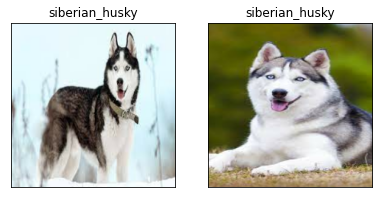

In [173]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)